#  Оптимизизация маркетинговых затрат согласно данным от Яндекс.Афиши

## Описание проекта

Поможем маркетологам в оптимизизации маркетинговых затрат согласно следующим данным от Яндекс.Афиши с июня 2017 по конец мая 2018 года:

- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Изучим:

- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент,
- когда клиент окупается.

* [Шаг 1. Загрузим данные и подготовим их к анализу](#chapter1)
* [Шаг 2. Построим отчёты и посчитаем метрики](#chapter2)
    * [Продукт](#chapter2_1)
    * [Продажи](#chapter2_2)
    * [Маркетинг](#chapter2_3)
* [Шаг 3. Напишем вывод: порекомендуем маркетологам, куда и сколько им стоит вкладывать денег?](#chapter3)
* [Выводы](#chapterend)

## Шаг 1. Загрузим данные и подготовим их к анализу<a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import display
from scipy import stats as st

visits_log = pd.read_csv('/datasets/visits_log.csv')
orders_log = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [2]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Таблица `visits_log` (лог сервера с информацией о посещениях сайта):

- *Device* — категория устройства пользователя;
- *End Ts* — дата и время окончания сессии;
- *Source Id* — идентификатор рекламного источника, из которого пришел пользователь;
- *Start Ts* — дата и время начала сессии;
- *Uid* — уникальный идентификатор пользователя.

Дататасет состоит из 5 столбцов и 359400 строк. Пропуски отсутствуют. Изменим названия столбцов:

- *Device* — на *device*;
- *End Ts* — на *session_end_ts*;
- *Source Id* — на *source_id*;
- *Start Ts* — на *session_start_ts*;
- *Uid* — на *user_id*.

In [3]:
visits_log.columns = ['device', 'session_end_ts', 'source_id', 'session_start_ts', 'user_id']
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device              359400 non-null object
session_end_ts      359400 non-null object
source_id           359400 non-null int64
session_start_ts    359400 non-null object
user_id             359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Таблица `orders_log` (информация о заказах):

- *Buy Ts* — дата и время заказа;
- *Revenue* — выручка Яндекс.Афиши с этого заказа;
- *Uid* — уникальный id пользователя, который сделал заказ.

Дататасет состоит из 3 столбцов и 50415 строк. Пропуски отсутствуют. Изменим названия столбцов:

- *Buy Ts* — на *order_ts*;
- *Revenue* — на *revenue*;
- *Uid* — на *user_id*.

In [5]:
orders_log.columns = ['order_ts', 'revenue', 'user_id']
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
order_ts    50415 non-null object
revenue     50415 non-null float64
user_id     50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [6]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Таблица *costs* (информация о затратах на маркетинг):

- *source_id* — идентификатор рекламного источника;
- *dt* — дата;
- *costs* — затраты на этот рекламный источник в этот день.

Дататасет состоит из 3 столбцов и 50415 строк. Пропуски отсутствуют. Названия столбцов не требуют изменений.

Изменим формат поля *source_id* таблицы `visits_log` с int64 на int16 методом `astype()`.

In [7]:
visits_log['source_id'] = visits_log['source_id'].astype(np.int16())

Преобразуем строки в столбцах *session_end_ts* и *session_start_ts* таблицы `visits_log` в формат даты.

In [8]:
visits_log['session_end_ts'] = pd.to_datetime(visits_log['session_end_ts'], format='%Y-%m-%dT%H:%M:%S')
visits_log['session_start_ts'] = pd.to_datetime(visits_log['session_start_ts'], format='%Y-%m-%dT%H:%M:%S')

Преобразуем строки в столбце *order_ts* таблицы `orders_log` в формат даты.

In [9]:
orders_log['order_ts'] = pd.to_datetime(orders_log['order_ts'], format='%Y-%m-%dT%H:%M:%S')

Преобразуем строки в столбце *dt* таблицы `costs` в формат даты.

In [10]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%dT%H:%M:%S')

## Вывод:

Данные распределены по трём датасетам: `visits_log`, `orders_log`, `costs`. Названия столбцов изменены. Пропуски и дубликаты отсутствуют, типы данных преобразованы.

In [11]:
visits_log.duplicated().sum()

0

In [12]:
orders_log.duplicated().sum()

0

In [13]:
costs.duplicated().sum()

0

## Шаг 2. Построим отчёты и посчитаем метрики<a class="anchor" id="chapter2"></a>

## Продукт<a class="anchor" id="chapter2_1"></a>

- Посчитаем, сколько людей посещают сайт Яндекс.Афиши в день **DAU** (*daily active users*), неделю **WAU** (*weekly active users*), месяц **MAU** (*monthly active users*). Для этого выделим в отдельные столбцы год, месяц и неделю, а также полную дату.

In [14]:
visits_log['session_year']  = visits_log['session_start_ts'].dt.year
visits_log['session_month'] = visits_log['session_start_ts'].dt.month
visits_log['session_week']  = visits_log['session_start_ts'].dt.week
visits_log['session_date'] = visits_log['session_start_ts'].dt.date

Сгруппируем данные по уникальным пользователям и найдём среднее.

In [15]:
dau_total = visits_log.groupby('session_date').agg({'user_id': 'nunique'}).mean()
wau_total = visits_log.groupby(['session_year', 'session_week']).agg({'user_id': 'nunique'}).mean()
mau_total = visits_log.groupby(['session_year', 'session_month']).agg({'user_id': 'nunique'}).mean()

Количество уникальных пользователей в день:

In [16]:
dau_total

user_id    907.991758
dtype: float64

Количество уникальных пользователей в неделю:

In [17]:
wau_total

user_id    5716.245283
dtype: float64

Количество уникальных пользователей в месяц:

In [18]:
mau_total

user_id    23228.416667
dtype: float64

- Посчитаем количество сессий в день. Для этого создадим сводную таблицу `sessions_number`, сгруппируем данные по дате, посчитаем общее количество и количество уникальных пользовательских сессий и выведем на экран.

In [19]:
sessions_number = visits_log.pivot_table(index='session_date', values='user_id', aggfunc=['count', 'nunique'])
sessions_number.head()

count      nunique        
             user_id session_date user_id
session_date                             
2017-06-01       664            1     605
2017-06-02       658            1     608
2017-06-03       477            1     445
2017-06-04       510            1     476
2017-06-05       893            1     820

Построим график.

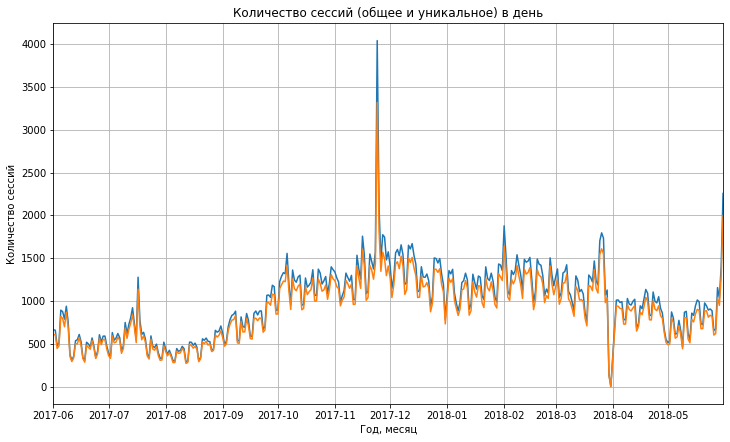

In [20]:
plt.figure(figsize=(12, 7))
sessions_number['count']['user_id'].plot()
sessions_number['nunique']['user_id'].plot()
plt.grid(True)
ax = plt.gca()
ax.set_xlabel('Год, месяц')
ax.set_ylabel('Количество сессий')
plt.title('Количество сессий (общее и уникальное) в день');

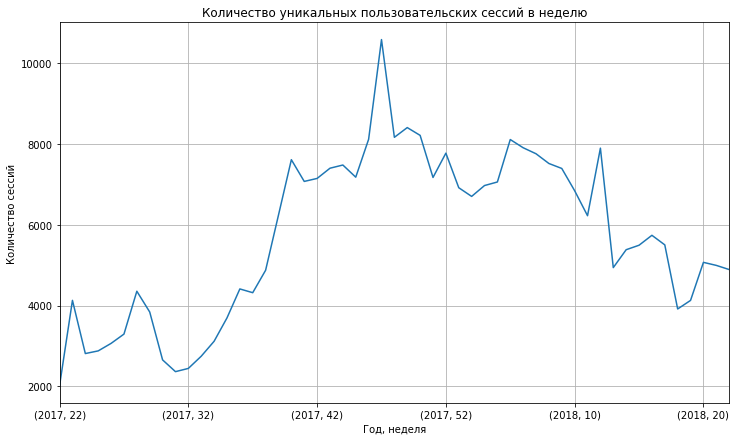

In [21]:
wau = visits_log.groupby(['session_year', 'session_week']).agg({'user_id': 'nunique'})
wau.plot(figsize=(12, 7), legend=False)
plt.grid(True)
ax = plt.gca()
ax.grid(which='minor')
ax.set_xlabel('Год, неделя')
ax.set_ylabel('Количество сессий')
plt.title('Количество уникальных пользовательских сессий в неделю');

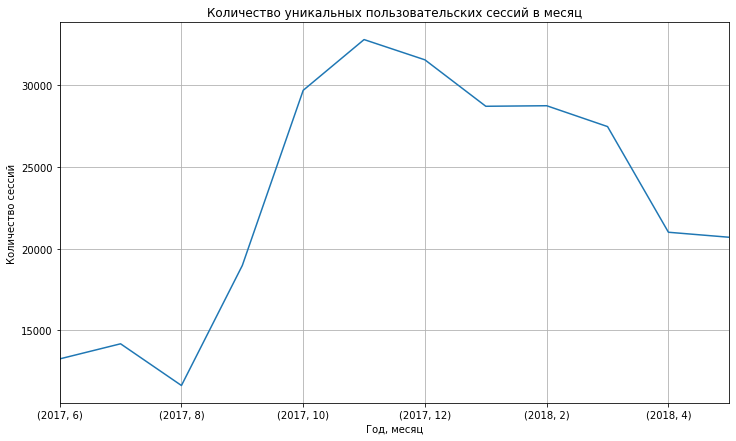

In [22]:
mau = visits_log.groupby(['session_year', 'session_month']).agg({'user_id': 'nunique'})
mau.plot(figsize=(12, 7), legend=False)
plt.grid(True)
ax = plt.gca()
ax.set_xlabel('Год, месяц')
ax.set_ylabel('Количество сессий')
plt.title('Количество уникальных пользовательских сессий в месяц');

Найдём дату пикового значения.

In [23]:
sessions_number[sessions_number['count']['user_id'] == sessions_number['count']['user_id'].max()]

count      nunique        
             user_id session_date user_id
session_date                             
2017-11-24      4042            1    3319

**Вывод:** пик пришёлся на 24-е ноября. Аномалия? Подготовка к Новому году? Иные причины?

- Посчитаем, сколько длится одна сессия. Найдём разницу между окончанием и началом сессии в секундах, поделим на 60,чтобы найти минуты, сохраним результат в столбец *session_duration_min*.

In [24]:
visits_log['session_duration_min'] = (visits_log['session_end_ts'] - visits_log['session_start_ts']).dt.seconds / 60

Проанализируем *session_duration_min* методом `describe()`.

In [25]:
visits_log['session_duration_min'].describe()

count    359400.000000
mean         10.725108
std          16.938913
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max        1408.000000
Name: session_duration_min, dtype: float64

На основании результата построим гистограмму распределения продолжительности сессий, ограничив продолжительность 50 минутами.

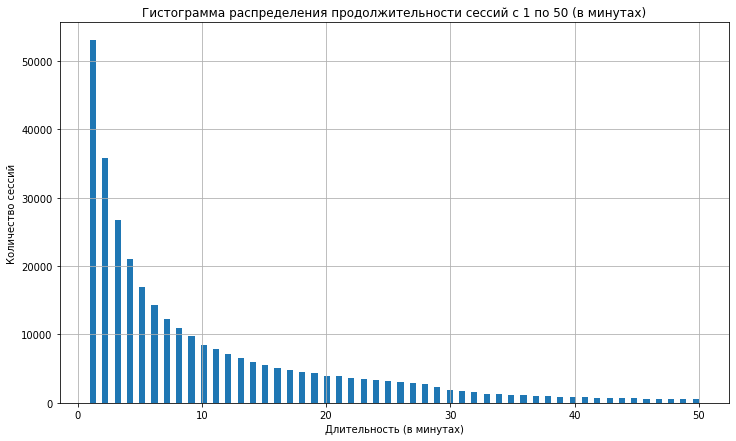

In [26]:
visits_log[visits_log['session_duration_min'] > 0]['session_duration_min'].hist(range=(1, 50), figsize=(12, 7), bins=99)
ax = plt.gca()
ax.set_xlabel('Длительность (в минутах)')
ax.set_ylabel('Количество сессий')
plt.title('Гистограмма распределения продолжительности сессий с 1 по 50 (в минутах)');

**Вывод:** чаще всего встречается значение 1, средняя продолжительность сессии (**ASL** — *average session length*) составляет одну минуту.

In [27]:
visits_log['session_duration_min'].mean()

10.725108143201632

In [28]:
visits_log['session_duration_min'].median()

5.0

- Исследуем, как часто люди возвращаются при помощи когортного анализа. Сформируем когорты по посещениям.

In [29]:
first_visit_date_by_users = visits_log.groupby('user_id')['session_start_ts'].min()
first_visit_date_by_users.name = 'first_visit_date'
visits_log = visits_log.join(first_visit_date_by_users,on='user_id')
visits_log['visit_month'] = visits_log['session_start_ts'].astype('datetime64[M]')
visits_log['first_visit_date'] = visits_log['first_visit_date'].astype('datetime64[M]')

Построим сводную таблицу методом `pivot_table()`:
- в строках *index* когорта пользователей *first_visit_date*;
- в столбцах *columns* — месяц посещения *session_month*;
- значениями *values* — количество уникальных пользователей *user_id*;
- в аргументе *aggfunc* укажем *nunique*.

In [30]:
user_session_pivot = visits_log.pivot_table(
    index='first_visit_date',
    columns='visit_month',
    values='user_id',
    aggfunc='nunique')
user_session_pivot

visit_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_visit_date,,,,,,,,,,,,
2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,NaN,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0
2017-08-01,NaN,NaN,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0
2017-09-01,NaN,NaN,NaN,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0
2017-10-01,NaN,NaN,NaN,NaN,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0
2017-11-01,NaN,NaN,NaN,NaN,NaN,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,25268.0,1410.0,960.0,786.0,512.0,481.0
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22624.0,1351.0,890.0,565.0,458.0
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22197.0,1267.0,565.0,446.0


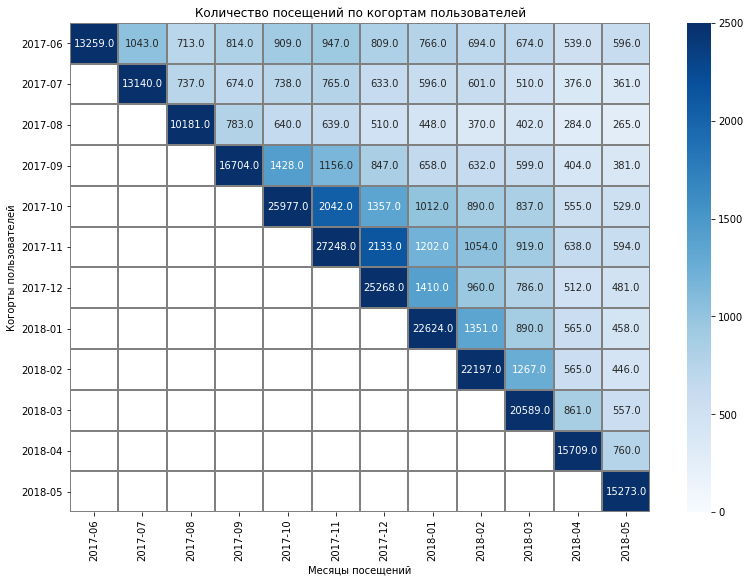

In [31]:
plt.figure(figsize=(13, 9))
plt.title('Количество посещений по когортам пользователей')
sns.heatmap(user_session_pivot, cmap='Blues', annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmin=0, vmax=2500)
ax = plt.gca()
ax.set_xticklabels(user_session_pivot.columns.strftime('%Y-%m'))
ax.set_yticklabels(user_session_pivot.index.strftime('%Y-%m'))
ax.set_xlabel('Месяцы посещений')
ax.set_ylabel('Когорты пользователей');

**Вывод:** после первого месяца количество посетителей в когорте резко снижается. Осенью действительно наблюдается всплеск посетителей.

Рассчитаем коэффициент удержания **Retention Rate**. Для каждой строки датафрейма вычислим *lifetime* пользователя в рамках когорты.

In [32]:
visits_log['cohort_lifetime'] = (visits_log['visit_month'] - visits_log['first_visit_date']) / np.timedelta64(1,'M')
visits_log['cohort_lifetime'] = visits_log['cohort_lifetime'].round().astype('int')

Сгруппируем данные по когорте и *lifetime*. Посчитаем для каждой когорты количество активных пользователей на каждый месяц.

In [33]:
cohorts_retention_rate = visits_log.groupby(['first_visit_date','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()
cohorts_retention_rate.head()

,first_visit_date,cohort_lifetime,user_id
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю.

In [34]:
initial_users_count = cohorts_retention_rate[cohorts_retention_rate['cohort_lifetime'] == 0][['first_visit_date','user_id']]
initial_users_count

,first_visit_date,user_id
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Переименуем столбец *user_id* в *cohort_users* методом `rename()`. Параметру *columns* передадим словарь, где ключ — старое название столбца, а значение — новое.

In [35]:
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'})
initial_users_count

,first_visit_date,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Объединим данные по когортам с исходным количеством пользователей в когорте.

In [36]:
cohorts_retention_rate = cohorts_retention_rate.merge(initial_users_count,on='first_visit_date')
cohorts_retention_rate.head()

,first_visit_date,cohort_lifetime,user_id,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


Наконец, рассчитаем **Retention Rate**. Разделим количество активных пользователей в каждый месяц на исходное число пользователей в когорте.

In [37]:
cohorts_retention_rate['retention'] = cohorts_retention_rate['user_id'] / cohorts_retention_rate['cohort_users']

Построим сводную таблицу и создадим тепловую карту.

In [38]:
retention_pivot = cohorts_retention_rate.pivot_table(
    index='first_visit_date',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_date,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


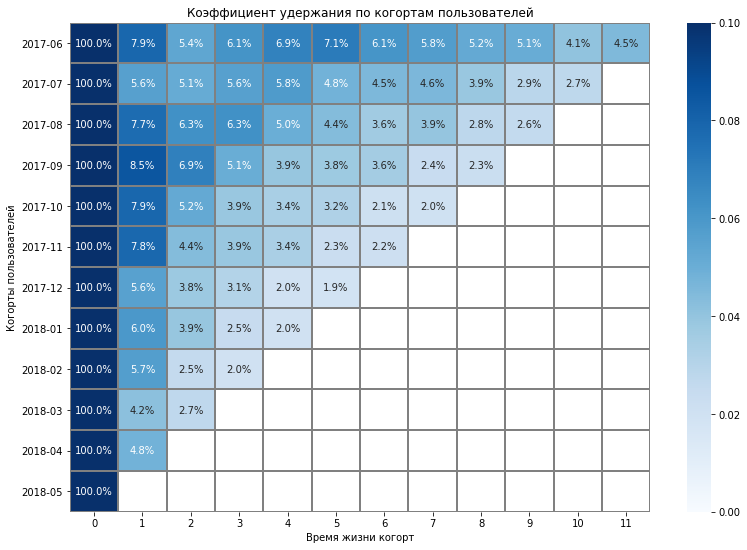

In [39]:
plt.figure(figsize=(13, 9))
plt.title('Коэффициент удержания по когортам пользователей')
sns.heatmap(retention_pivot, cmap='Blues', annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0, vmax=0.1)
ax = plt.gca()
ax.set_yticklabels(retention_pivot.index.strftime('%Y-%m'))
ax.set_xlabel('Время жизни когорт')
ax.set_ylabel('Когорты пользователей');

**Вывод:** после первого месяца количество посетителей в когорте резко снижается.

## Продажи<a class="anchor" id="chapter2_2"></a>

- Посчитаем, когда люди начинают покупать. Найдём дату первой покупки, сгруппируем пользователей таблицы `orders_log`, определим самое раннее время, сохраним результат в таблицу `first_order_date_by_users` и выведем на экран.

In [40]:
first_order_date_by_users = orders_log.groupby('user_id')['order_ts'].min()
first_order_date_by_users.name = 'first_order_month'
first_order_date_by_users.head()

user_id
313578113262317    2018-01-03 21:51:00
1575281904278712   2017-06-03 10:13:00
2429014661409475   2017-10-11 18:33:00
2464366381792757   2018-01-28 15:54:00
2551852515556206   2017-11-24 10:14:00
Name: first_order_month, dtype: datetime64[ns]

Найдём разницу между таблицами `first_order_date_by_users` и `first_visit_date_by_users`. Сохраним результат в переменную `order_time`, удалим пропуски и проанализируем методом `describe()`.

In [41]:
order_time = first_order_date_by_users - first_visit_date_by_users
order_time = order_time.dropna()
order_time.describe()

count                      36523
mean     16 days 21:40:10.550064
std      47 days 01:44:46.481416
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:16:00
75%              2 days 00:17:00
max            363 days 07:04:00
dtype: object

**Вывод:** когда люди начинают покупать? Сразу. Если они не купили ничего в первые 15 минут и не вернулись через пару дней, то, скорее всего, уже ничего не купят.

In [42]:
order_time.mean()

Timedelta('16 days 21:40:10.550064')

In [43]:
order_time.median()

Timedelta('0 days 00:16:00')

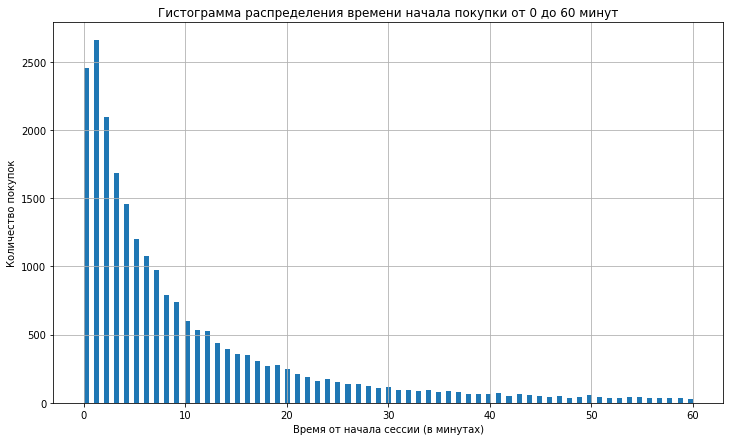

In [44]:
order_time.astype('timedelta64[m]')[order_time.astype('timedelta64[m]') <= 60].hist(figsize=(12, 7), bins=121)
ax = plt.gca()
ax.set_xlabel('Время от начала сессии (в минутах)')
ax.set_ylabel('Количество покупок')
plt.title('Гистограмма распределения времени начала покупки от 0 до 60 минут');

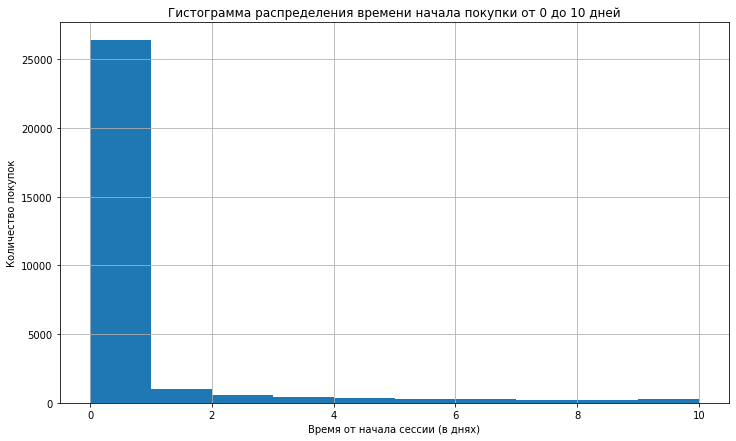

In [45]:
order_time.astype('timedelta64[D]')[order_time.astype('timedelta64[D]') <= 10].hist(figsize=(12, 7), bins=10)
ax = plt.gca()
ax.set_xlabel('Время от начала сессии (в днях)')
ax.set_ylabel('Количество покупок')
plt.title('Гистограмма распределения времени начала покупки от 0 до 10 дней');

**Вывод:** люди покупают сразу.

- Посчитаем, сколько раз покупают за период. Добавим в таблицу `orders_log` столбцы *order_month* — месяц покупки и *first_order_month* — дата первой покупки.

In [46]:
orders_log = orders_log.join(first_order_date_by_users,on='user_id')
orders_log['order_month'] = orders_log['order_ts'].astype('datetime64[M]')
orders_log['first_order_month'] = orders_log['first_order_month'].astype('datetime64[M]')

Построим сводную таблицу `user_order_pivot` методом `pivot_table()`:
- в строках *index* будет когорта пользователей *first_order_month*;
- в столбцах *columns* — месяц совершения покупки *order_month*;
- значениями *values* станет количество уникальных пользователей *user_id*;
- в аргументе *aggfunc* укажем *nunique*.

Выведем результат на экран.

In [47]:
user_order_pivot = orders_log.pivot_table(
    index='first_order_month',
    columns='order_month',
    values='user_id',
    aggfunc='nunique')
user_order_pivot

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,2023.0,61.0,50.0,54.0,88.0,67.0,62.0,47.0,58.0,45.0,45.0,53.0,NaN
2017-07-01,NaN,1923.0,52.0,57.0,64.0,49.0,38.0,36.0,39.0,42.0,22.0,26.0,NaN
2017-08-01,NaN,NaN,1370.0,58.0,53.0,44.0,40.0,32.0,30.0,44.0,19.0,31.0,NaN
2017-09-01,NaN,NaN,NaN,2581.0,130.0,100.0,74.0,52.0,64.0,66.0,37.0,43.0,NaN
2017-10-01,NaN,NaN,NaN,NaN,4340.0,206.0,123.0,92.0,93.0,72.0,56.0,67.0,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,4081.0,222.0,120.0,106.0,81.0,48.0,62.0,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4383.0,146.0,103.0,97.0,50.0,63.0,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3373.0,114.0,83.0,43.0,45.0,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3651.0,118.0,58.0,39.0,NaN


In [48]:
user_order_pivot = orders_log[orders_log['order_month'] != '2018-06-01'].pivot_table(
    index='first_order_month',
    columns='order_month',
    values='user_id',
    aggfunc='nunique')
user_order_pivot

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_order_month,,,,,,,,,,,,
2017-06-01,2023.0,61.0,50.0,54.0,88.0,67.0,62.0,47.0,58.0,45.0,45.0,53.0
2017-07-01,NaN,1923.0,52.0,57.0,64.0,49.0,38.0,36.0,39.0,42.0,22.0,26.0
2017-08-01,NaN,NaN,1370.0,58.0,53.0,44.0,40.0,32.0,30.0,44.0,19.0,31.0
2017-09-01,NaN,NaN,NaN,2581.0,130.0,100.0,74.0,52.0,64.0,66.0,37.0,43.0
2017-10-01,NaN,NaN,NaN,NaN,4340.0,206.0,123.0,92.0,93.0,72.0,56.0,67.0
2017-11-01,NaN,NaN,NaN,NaN,NaN,4081.0,222.0,120.0,106.0,81.0,48.0,62.0
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4383.0,146.0,103.0,97.0,50.0,63.0
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3373.0,114.0,83.0,43.0,45.0
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3651.0,118.0,58.0,39.0


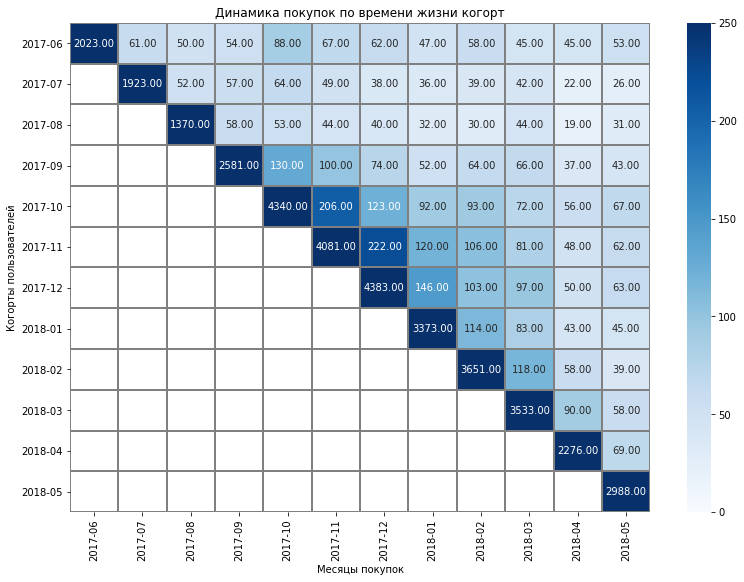

In [49]:
plt.figure(figsize=(13, 9))
plt.title('Динамика покупок по времени жизни когорт')
sns.heatmap(user_order_pivot, cmap='Blues', annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin=0, vmax=250)
ax = plt.gca()
ax.set_xticklabels(user_order_pivot.columns.strftime('%Y-%m'))
ax.set_yticklabels(user_order_pivot.index.strftime('%Y-%m'))
ax.set_xlabel('Месяцы покупок')
ax.set_ylabel('Когорты пользователей');

**Вывод:** после первого месяца количество покупателей в когорте резко снижается, ноябрьский всплеск на месте.

- Посчитаем средний чек. Для этого сгруппируем таблицу `orders_log` по когорте *first_order_month* и месяцу совершения заказа *order_month*, найдём суммарный чек и количество покупателей.

In [50]:
orders_grouped_by_cohorts = orders_log.groupby(
    ['first_order_month','order_month']).agg({'revenue':'sum','user_id':'nunique'})
orders_grouped_by_cohorts.head()

revenue  user_id
first_order_month order_month                  
2017-06-01        2017-06-01   9557.49     2023
                  2017-07-01    981.82       61
                  2017-08-01    885.34       50
                  2017-09-01   1931.30       54
                  2017-10-01   2068.58       88

Найдём средний чек покупателя *revenue_per_user* — разделим показатель *revenue* на *user_id*: 

In [51]:
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['user_id']

Построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки и оценим, как изменяется средний чек с течением времени.

In [52]:
orders_grouped_by_cohorts.pivot_table(
    index='first_order_month',columns='order_month',values='revenue_per_user',aggfunc='mean') 

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026,NaN


Найдём, как изменяется средний чек в зависимости от времени, прошедшего с момента первой покупки. Из месяца совершения заказа *order_month* вычтем месяц когорты *first_order_month*, сохраним в столбец *cohort_lifetime*.

In [53]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = (
    orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month'])

Поделим *cohort_lifetime* на константу `np.timedelta64(1, 'M')`, чтобы узнать, сколько величин длиной в 1 месяц содержится в *cohort_lifetime*. Округлим значения столбца *cohort_lifetime* методом `round()`, а затем приведём их к целочисленному типу методом `astype('int')`.

In [54]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

Оставим в данных о месяце первого заказа только год и месяц, применив метод `dt.strftime()`.

In [55]:
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')

Построим сводную таблицу изменения среднего чека, где в столбцах будет *lifetime*, а строках — когорты. Выведем результат на экран.

In [56]:
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(
    index='first_order_month',columns='cohort_lifetime',values='revenue_per_user',aggfunc='mean')
revenue_per_user_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151
2017-07,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN,NaN
2017-09,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN,NaN,NaN
2017-10,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN,NaN,NaN,NaN
2017-11,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN,NaN,NaN,NaN,NaN
2017-12,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.135636,8.721228,12.365542,11.199767,4.699556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.156987,8.610000,4.942414,6.941026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим тепловую карту.

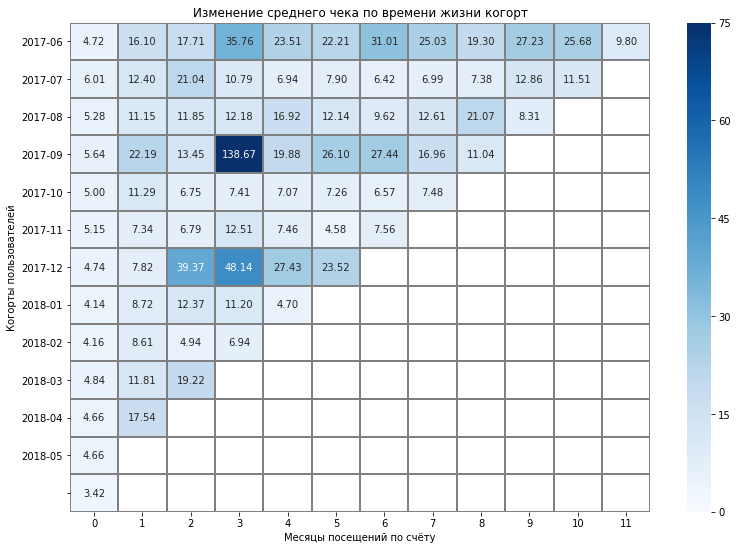

In [57]:
plt.figure(figsize=(13, 9))
plt.title('Изменение среднего чека по времени жизни когорт')
sns.heatmap(revenue_per_user_pivot, cmap='Blues', annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin=0, vmax=75)
ax = plt.gca()
ax.set_yticklabels(retention_pivot.index.strftime('%Y-%m'))
ax.set_xlabel('Месяцы посещений по счёту')
ax.set_ylabel('Когорты пользователей');

**Вывод:** у первых покупок минимальный чек: покупатели прицениваются.

- Посчитаем, сколько денег приносят пользователи (**LTV**).

Получим месяц первой покупки каждого покупателя.

In [58]:
first_orders = orders_log.groupby('user_id').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['user_id', 'first_order_month']
first_orders.head()

,user_id,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


Посчитаем количество новых покупателей *n_buyers* за каждый месяц.

In [59]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'user_id': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку. Сбросим индекс методом `reset_index()`.

In [60]:
cohorts = orders_log.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92
77,2018-05-01,2018-05-01,13925.76


Добавим в таблицу `cohorts` данные о том, сколько людей первый раз совершили покупку в каждый месяц.

In [61]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87
75,2018-04-01,2276,2018-04-01,10600.69
76,2018-04-01,2276,2018-05-01,1209.92
77,2018-05-01,2988,2018-05-01,13925.76


Добавим возраст (*age*) когорты.

In [62]:
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,n_buyers,order_month,revenue,age
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4


Найдём **LTV**, разделив валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. Построим сводную таблицу.

In [63]:
margin_rate = 1

report['ltv'] = margin_rate * report['revenue'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
    
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.02253,0.735502,0.95044,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.14182,0.161232,0.147145,0.155673,
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.28354,0.210664,0.405007,0.292212,0.187978,,
2017-09-01,5.644529,1.11759,0.52093,3.97579,0.400558,0.647067,0.701608,0.24315,0.184006,,,
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.15156,0.120362,0.0848157,0.11547,,,,
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,,,,,
2017-12-01,4.738191,0.260374,0.925097,1.06527,0.31293,0.338047,,,,,,
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.0626979,,,,,,,
2018-02-01,4.156987,0.278274,0.0785155,0.0741441,,,,,,,,


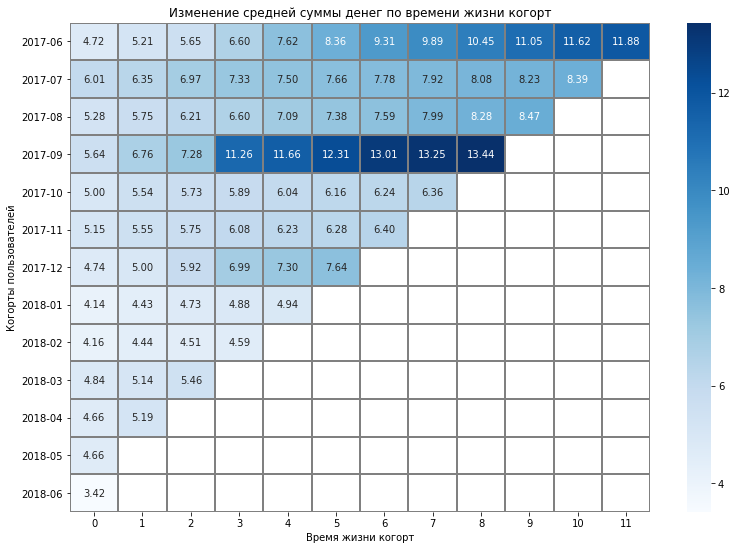

In [64]:
plt.figure(figsize=(13, 9))
plt.title('Изменение средней суммы денег по времени жизни когорт')
sns.heatmap(output.cumsum(axis=1), cmap='Blues', annot=True, fmt='.2f', linewidths=1, linecolor='gray') #, vmin=0, vmax=75)
ax = plt.gca()
ax.set_yticklabels(output.cumsum(axis=1).index.strftime('%Y-%m'))
ax.set_xlabel('Время жизни когорт')
ax.set_ylabel('Когорты пользователей');

Посчитаем **LTV** каждой когорты. Сложим **LTV** по месяцам.

In [65]:
LTV = output.sum(axis=1).reset_index()
LTV.columns = ['first_order_month', 'LTV']
LTV

,first_order_month,LTV
0,2017-06-01,11.879234
1,2017-07-01,8.386854
2,2017-08-01,8.471723
3,2017-09-01,13.435227
4,2017-10-01,6.360242
5,2017-11-01,6.395244
6,2017-12-01,7.639913
7,2018-01-01,4.940151
8,2018-02-01,4.587921
9,2018-03-01,5.455253


В среднем каждый покупатель из первой когорты принес меньше 12 рублей выручки за год «жизни».

Сразу посчитаем **CAC** (*customer acquisition cost*) — стоимость привлечения клиента. Для этого найдём месяц каждой затраты и сгруппируем по месяцам.

In [66]:
costs['order_month'] = costs['dt'].astype('datetime64[M]')
monthly_costs = costs.groupby(['order_month']).agg({'costs':'sum'})
monthly_costs

,costs
order_month,
2017-06-01,18015.00
2017-07-01,18240.59
2017-08-01,14790.54
2017-09-01,24368.91
2017-10-01,36322.88
2017-11-01,37907.88
2017-12-01,38315.35
2018-01-01,33518.52
2018-02-01,32723.03


Посчитаем **CAC** каждой когорты. Поделим расходы за каждый месяц на количество людей в когорте.

In [67]:
CAC = monthly_costs.reset_index()['costs'] / cohort_sizes['n_buyers']
CAC

0      8.905091
1      9.485486
2     10.796015
3      9.441654
4      8.369327
5      9.288870
6      8.741809
7      9.937302
8      8.962758
9      8.608907
10     9.793225
11     7.437841
12          NaN
dtype: float64

**LTV** июньской когорты составляет меньше 12 рублей, **CAC** — меньше 9.
Привлечение одного покупателя в среднем обошлось компании в 9 рублей. Валовая прибыль с каждого из них: 12 рублей. Вложения в привлечение покупателей окупились.

## Маркетинг<a class="anchor" id="chapter2_3"></a>

Посчитаем, сколько денег потратили. Всего:

In [68]:
costs['costs'].sum()

329131.62

На каждый источник:

In [69]:
costs_per_source = costs.groupby('source_id').sum()
costs_per_source

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


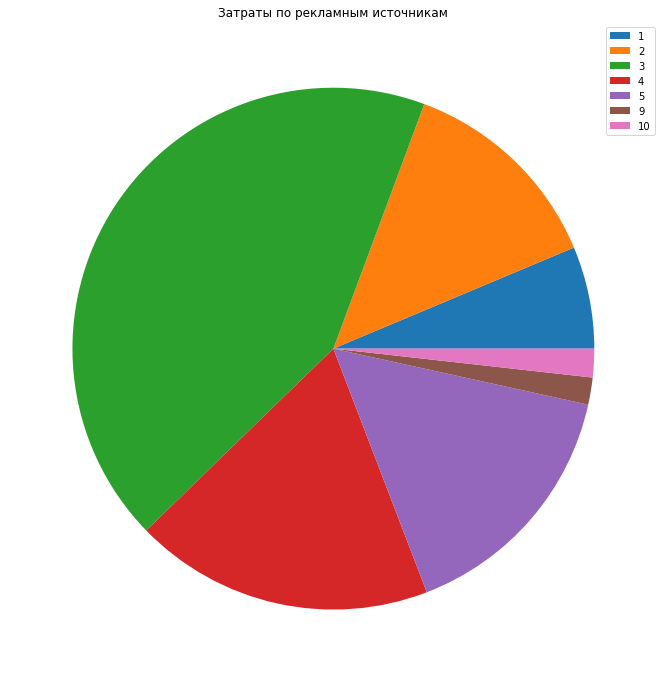

In [70]:
plt.figure(figsize=(12, 12))
plt.pie(costs.groupby('source_id').sum())
plt.legend(labels = costs.groupby('source_id').sum().index)
plt.title('Затраты по рекламным источникам');

По времени:

In [71]:
source_time_costs = costs.pivot_table(index='source_id', columns='order_month', values='costs', aggfunc='sum')
source_time_costs

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


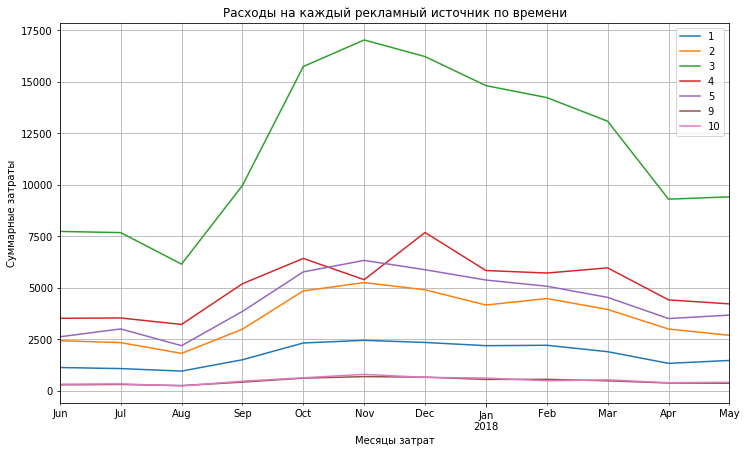

In [72]:
plt.figure(figsize=(12, 7))
plt.title('Расходы на каждый рекламный источник по времени')
for i in source_time_costs.index:
    source_time_costs.loc[i, :].plot(x='order_month', label = i)
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.grid(which='minor')
ax.set_xlabel('Месяцы затрат')
ax.set_ylabel('Суммарные затраты');

**Вывод:** наибольшие затраты на рекламный источник № 3. Пиковые расходы на него совпадают с пиком посещений пользователей.

Посчитаем сколько стоило привлечение одного покупателя из каждого источника. Сгруппируем количество уникальных посетителей по каждому источнику.

In [73]:
visits_per_source = visits_log.groupby(['source_id']).agg({'user_id':'nunique'})
visits_per_source

,user_id
source_id,
1,18999
2,26245
3,74756
4,83525
5,56974
6,6
7,34
9,9264
10,8067


Объединим данные по затратам на каждый источник с количеством уникальных пользователей по каждому источнику.

In [74]:
costs_per_source = costs_per_source.merge(visits_per_source,on='source_id')
costs_per_source

,costs,user_id
source_id,,
1,20833.27,18999
2,42806.04,26245
3,141321.63,74756
4,61073.60,83525
5,51757.10,56974
9,5517.49,9264
10,5822.49,8067


In [75]:
costs_per_source['costs_per_user'] = costs_per_source['costs'] / costs_per_source['user_id']
costs_per_source = costs_per_source.sort_values(by='costs_per_user', ascending=False)
costs_per_source

,costs,user_id,costs_per_user
source_id,,,
3,141321.63,74756,1.890439
2,42806.04,26245,1.631017
1,20833.27,18999,1.096546
5,51757.10,56974,0.908434
4,61073.60,83525,0.731201
10,5822.49,8067,0.721766
9,5517.49,9264,0.595584


In [76]:
costs_per_source_bar = costs_per_source['costs_per_user'].reset_index().sort_values(by='costs_per_user', ascending=False)

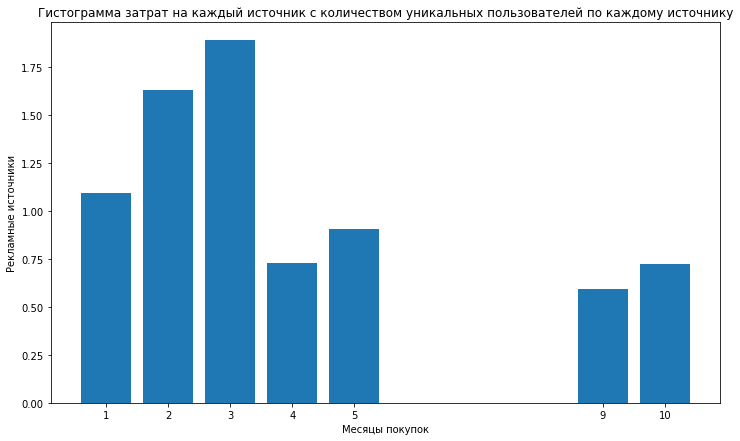

In [77]:
plt.figure(figsize=(12, 7))
plt.bar(costs_per_source_bar['source_id'], costs_per_source_bar['costs_per_user'])
ax = plt.gca()
ax.set_xticks(costs_per_source_bar['source_id'])
ax.set_xlabel('Месяцы покупок')
ax.set_ylabel('Рекламные источники')
plt.title('Гистограмма затрат на каждый источник с количеством уникальных пользователей по каждому источнику');

**Вывод:** самым затратным с точки зрения привлечения покупателя является рекламный источник № 3.

Посчитаем, насколько окупились расходы (**ROI** — *return on investments*). Чтобы не путать окупаемость бизнеса с окупаемостью маркетинга, вместо **ROI** рассчитывают **ROMI** (*return on marketing investments*).

Добавим данные о расходах в отчёт и посчитаем **CAC**.

In [78]:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='order_month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531,18015.0,8.905091


Для расчёта **ROMI** поделим **LTV** на **CAC**. Построим сводную таблицу и посчитаем накопительный **ROMI** при помощи метода `cumsum()`.

In [79]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
output_new = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')
output_new.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


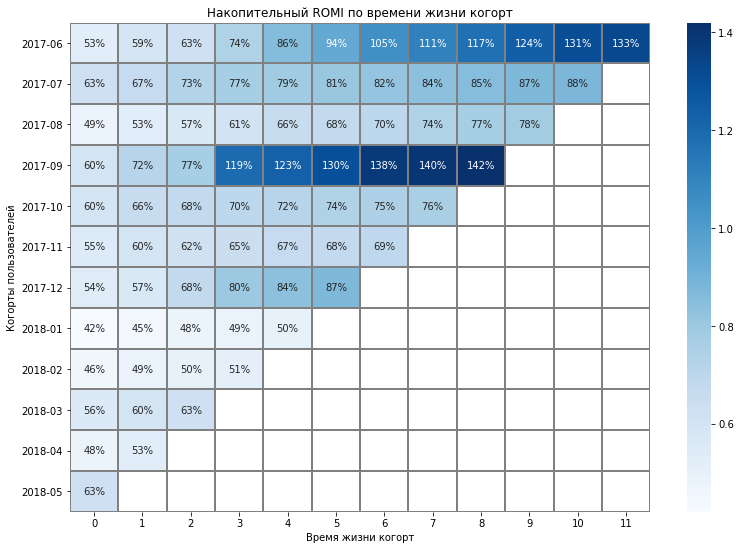

In [80]:
plt.figure(figsize=(13, 9))
plt.title('Накопительный ROMI по времени жизни когорт')
sns.heatmap(output_new.cumsum(axis=1).round(2), cmap='Blues', annot=True, fmt='.0%', linewidths=1, linecolor='gray')
ax = plt.gca()
ax.set_yticklabels(output_new.cumsum(axis=1).round(2).index.strftime('%Y-%m'))
ax.set_xlabel('Время жизни когорт')
ax.set_ylabel('Когорты пользователей');

Посчитаем среднюю когорту.

In [81]:
output_new.cumsum(axis=1).mean(axis=0)

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

**Вывод:** пока окупились только две когорты: июньская — за 7 месяцев и сентябрьская — за 4 месяца. Остальным для окупаемости требуется в среднем 8-10 месяцев.

Посчитаем, как менялось количество посещений с разных устройств по когортам.

In [82]:
visits_per_device = visits_log.pivot_table(
    index='device', columns='first_visit_date', values='user_id', aggfunc='nunique')
visits_per_device

first_visit_date,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
device,,,,,,,,,,,,
desktop,10127,9610,7635,12006,18787,20439,18653,15976,15700,14474,10864,10252
touch,4106,4354,3015,5488,8299,7862,7392,7216,6967,6460,5033,5153


Построим график.

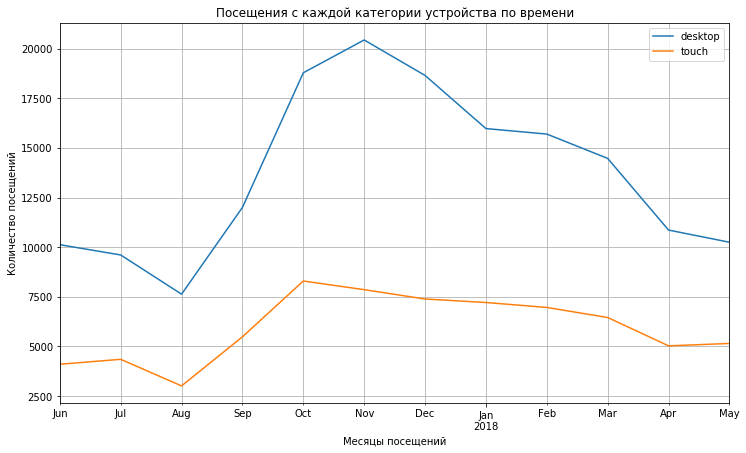

In [83]:
plt.figure(figsize=(12, 7))
plt.title('Посещения c каждой категории устройства по времени')
for i in visits_per_device.index:
    visits_per_device.loc[i, :].plot(x='first_visit_date', label = i)
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.grid(which='minor')
ax.set_xlabel('Месяцы посещений')
ax.set_ylabel('Количество посещений');

Посчитаем, как менялось количество посещений из разных рекламных источников по когортам.

In [84]:
visits_per_sources = visits_log.pivot_table(
    index='source_id', columns='first_visit_date', values='user_id', aggfunc='nunique')
visits_per_sources

first_visit_date,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1513.0,1282.0,910.0,1526.0,2239.0,2484.0,2120.0,1647.0,1553.0,1515.0,1112.0,1098.0
2,2202.0,1974.0,1263.0,2114.0,3105.0,3426.0,2623.0,2171.0,2086.0,2059.0,1472.0,1750.0
3,5199.0,4582.0,3593.0,5981.0,8551.0,9572.0,8244.0,7385.0,7292.0,6136.0,4249.0,3972.0
4,4602.0,4644.0,3440.0,5721.0,9414.0,10272.0,10099.0,8599.0,7883.0,7730.0,5647.0,5474.0
5,3566.0,4005.0,3249.0,5093.0,7587.0,6351.0,5632.0,5226.0,5084.0,3926.0,4086.0,3169.0
6,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN
7,2.0,2.0,2.0,2.0,6.0,1.0,9.0,4.0,2.0,1.0,1.0,2.0
9,1057.0,713.0,602.0,820.0,1039.0,1227.0,926.0,690.0,609.0,917.0,331.0,333.0
10,543.0,394.0,285.0,562.0,970.0,837.0,581.0,839.0,933.0,1003.0,492.0,628.0


Построим график.

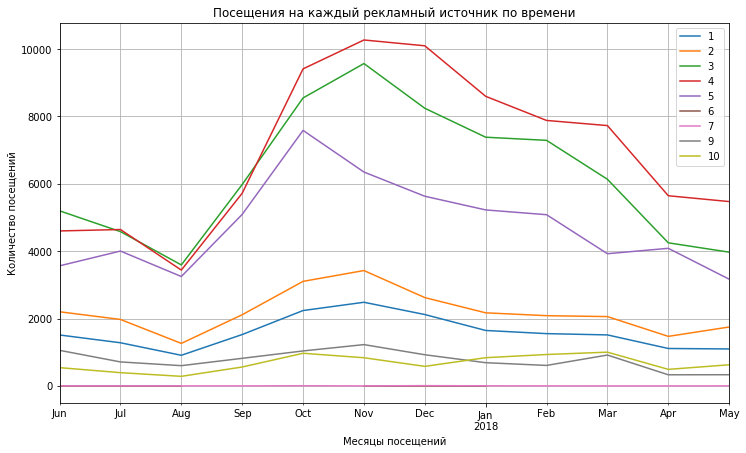

In [85]:
plt.figure(figsize=(12, 7))
plt.title('Посещения на каждый рекламный источник по времени')
for i in visits_per_sources.index:
    visits_per_sources.loc[i, :].plot(x='first_visit_date', label = i)
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.grid(which='minor')
ax.set_xlabel('Месяцы посещений')
ax.set_ylabel('Количество посещений');

**Вывод:** с компьютеров заходят почти в три раза чаще, чем со смартфонов. На источник № 4 приходится больше всего посещений, хотя затраты на него ниже, чем на источник № 3.

## Шаг 3. Напишем вывод: порекомендуем маркетологам, куда и сколько им стоит вкладывать денег?<a class="anchor" id="chapter3"></a>

Для определения наиболее перспективных рекламных источников сравним **ROMI** по каждому из них. Данная метрика выбрана как наиболее характерная и трудновычисляемая.

Чтобы вычислить **ROMI**, поставим каждому заказу в соответствие свой рекламный источник. Будем исходить из того, что дата и час, когда пользователь перешёл из рекламного источника, совпадают с датой и часом совершения покупки пользователем (вспомним, когда люди начинают покупать). Конечно, это предположение весьма условно: пользователь за час может перейти по нескольким ссылкам, и все они будут учтены. С другой стороны, пользователь может вспомнить о рекламе спустя несколько дней, сделать заказ, и это учтено не будет. Влияние маркетинга на заказы требует отдельного исследования, но для сравнения рекламных источников наше допущение вполне подойдёт.

Добавим столбец *source_id* в таблицу `orders_log`. Для этого вычленим дату и час начала сессии в таблице `visits_log` методом `astype('datetime64[h]')`.

In [86]:
visits_log['hour'] = visits_log['session_start_ts'].astype('datetime64[h]')

Аналогично найдём дату и час заказа в таблице `orders_log`.

In [87]:
orders_log['hour'] = orders_log['order_ts'].astype('datetime64[h]')

Выделим из таблицы `visits_log` нужные столбцы и сохраним в переменную `visits_source_log`.

In [88]:
visits_source_log = visits_log[['source_id', 'user_id', 'hour']]
visits_source_log.head()

,source_id,user_id,hour
0,4,16879256277535980062,2017-12-20 17:00:00
1,2,104060357244891740,2018-02-19 16:00:00
2,5,7459035603376831527,2017-07-01 01:00:00
3,9,16174680259334210214,2018-05-20 10:00:00
4,3,9969694820036681168,2017-12-27 14:00:00


Объединим таблицы `orders_log` и `visits_source_log` по уникальному идентификатору пользователя и времени сессии/заказа. Удалим пропуски и дубликаты.

In [89]:
orders_source_log = pd.merge(orders_log, visits_source_log, on=['user_id', 'hour'])
orders_source_log = orders_source_log.dropna().drop_duplicates()
orders_source_log.head()

,order_ts,revenue,user_id,first_order_month,order_month,hour,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01 00:00:00,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01 00:00:00,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01 00:00:00,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01 00:00:00,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01 07:00:00,3


Создадим функцию `find_romi_func()`.

In [90]:
def find_romi_func(orders_log_func, monthly_costs_func):
    """
    Функция получает на вход информацию о заказах и расходы по когортам.
    Выдаёт объект Series — среднюю когорту.
    
    """

    # Получим месяц первой покупки каждого покупателя.
    first_orders = orders_log_func.groupby('user_id').agg({'order_month': 'min'}).reset_index()
    first_orders.columns = ['user_id', 'first_order_month']

    # Посчитаем количество новых покупателей n_buyers за каждый месяц
    cohort_sizes = first_orders.groupby('first_order_month').agg({'user_id': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']

    # Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку.
    # Сбросим индекс методом reset_index()
    cohorts = orders_log_func.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()

    # Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц.
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

    # Добавим возраст (age) когорты.
    report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')

    # Найдём LTV, разделив валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте.
    # Построим сводную таблицу.

    margin_rate = 1
    report['ltv'] = margin_rate * report['revenue'] / report['n_buyers']
    output = report.pivot_table(
            index='first_order_month', 
            columns='age', 
            values='ltv', 
            aggfunc='mean')
    
    output.fillna('')

    # Посчитаем LTV каждой когорты. Сложим LTV по месяцам.
    LTV = output.sum(axis=1)
    
    # Добавим данные о расходах в отчёт и посчитаем CAC.
    report_new = pd.merge(report, monthly_costs_func, left_on='first_order_month', right_on='order_month')
    report_new['cac'] = report_new['costs'] / report_new['n_buyers']

    # Для расчёта ROMI поделим LTV на CAC.
    report_new['romi'] = report_new['ltv'] / report_new['cac']

    # Построим сводную таблицу и посчитаем накопительный ROMI при помощи метода cumsum().
    output_new = report_new.pivot_table(
            index='first_order_month', 
            columns='age', 
            values='romi', 
            aggfunc='mean')

    return output_new.cumsum(axis=1).mean(axis=0)

Создадим пустой датафрейм `orders_source` с заголовками в виде идентификаторов рекламных источников. Отсутствует информация по расходам на источники № 6, 7, 8, поэтому они исключены.

In [91]:
orders_source = pd.DataFrame(columns=[1, 2, 3, 4, 5, 9, 10])
orders_source

,1,2,3,4,5,9,10


В цикле по каждому идентификатору выберем заказы и расходы по когортам, функцией `find_romi_func` посчитаем **ROMI** и добавим в датафрейм.

In [92]:
for i in [1, 2, 3, 4, 5, 9, 10]:
    orders_source_func = orders_source_log[orders_source_log['source_id'] == i]
    monthly_costs_func = costs[costs['source_id'] == i].groupby(['order_month']).agg({'costs':'sum'})
    orders_source[i] = (find_romi_func(orders_source_func, monthly_costs_func))
    # display(i, find_romi_func(orders_source_func, monthly_costs_func))
orders_source

,1,2,3,4,5,9,10
age,,,,,,,
0,0.839073,0.390960,0.175169,0.450841,0.519852,0.328490,0.445319
1,0.948516,0.417437,0.180465,0.461190,0.543785,0.366268,0.453776
2,0.990084,0.483531,0.188075,0.464833,0.566198,0.397823,0.338548
3,1.040798,0.616487,0.194265,0.467563,0.595500,0.406387,0.387918
4,1.144642,0.680324,0.198199,0.476250,0.631699,0.413709,0.397906
5,1.246440,0.772923,0.207203,0.490946,0.685543,0.503059,0.357287
6,1.467653,0.734350,0.214769,0.503890,0.728370,0.491376,0.269976
7,1.593697,0.833170,0.221006,0.474268,0.812409,0.609993,0.290277
8,1.827216,0.906309,0.228066,0.449290,0.845432,0.663856,0.240584


Построим тепловую карту.

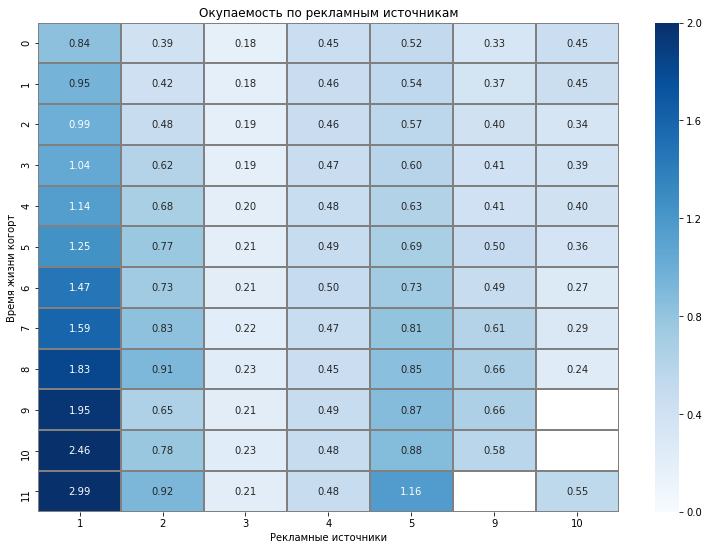

In [93]:
plt.figure(figsize=(13, 9))
plt.title('Окупаемость по рекламным источникам')
sns.heatmap(orders_source, cmap='Blues', annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin=0, vmax=2)
ax = plt.gca()
ax.set_xlabel('Рекламные источники')
ax.set_ylabel('Время жизни когорт');

Лучше всего окупаются рекламные источники № 1, 5 (за 4 и 10 месяцев соответственно). При этом у них низкие расходы и посещаемость, особенно у источника № 1.

## Выводы<a class="anchor" id="chapterend"></a>

**Рекламный источник № 1 обладает наибольшим потенциалом.**

Пик посещения пользователей пришёлся на 24-е ноября. Средняя продолжительность сессии (ASL — average session length) составляет одну минуту.

После первого месяца количество посетителей в когорте резко снижается.

Когда люди начинают покупать? Сразу. Если они не купили ничего в первые 15 минут и не вернулись через пару дней, то, скорее всего, уже ничего не купят.

У первых покупок минимальный чек: покупатели прицениваются.

Самые прибыльные когорты — июньская и сентябрьская. LTV июньской когорты составляет меньше 12 рублей, CAC — меньше 9. Привлечение одного покупателя в среднем обошлось компании в 9 рублей. Валовая прибыль с каждого из них: 12 рублей. Вложения в привлечение покупателей окупились.

Наибольшие затраты на рекламный источник № 3. Пиковые расходы на него совпадают с пиком посещений пользователей. Самым затратным с точки зрения привлечения покупателя также является рекламный источник № 3.

С компьютеров заходят почти в три раза чаще, чем со смартфонов. На источник № 4 приходится больше всего посещений, хотя затраты на него ниже, чем на источник № 3.